----
# Bayesian Data Analysis - Premier League Project
----

## Table of Contents
<ul>
    <li>Imports</li>
    <li>Background</li>
    <li>Data</li>
    <li>Model 1: Pooled model using ManU forwards</li>
    <li>Model 2: Hierarchical model using ManU forwards</li>
    <li>Model 3: Hierarchical model using new PL forwards</li>
    <li>Model comparison</li>
    <li>Sources</li>
</ul>

## Imports

In [1]:
import numpy as np
import arviz as az
import stan
import nest_asyncio
import warnings
import matplotlib.pyplot as plt
from scipy import stats

## Background

<b>Bayesian methods in sports</b><br>
The usage of Bayesian methods in sports analytics has been increasing due to the increasing amount of statistics gathered from sports and also the multiple advantages that Bayesian methods have (Santos-Fernandez et al., 2019). Bayesian approach allows for example to provide probabilistic estimates, add new information to models and make predictions that take the uncertainty into consideration. 

<b>Premier League</b><br>
As I am a big football fan, I have decided to do the project about the English Premier League. In the summer of 2021 a relatively big English football club, Manchester United, decided to re-sign Ronaldo from Juventus for a two-year contract with a transfer of about £12.85 million. On top of this, Ronaldo's yearly salary is estimated to be about £20 (Daily Mail, 2021).

<b>This project</b><br>
Despite of being a Tottenham Hotspur fan, in this project we are going to predict how many goals Ronaldo will score for Manchester United in season 2021-2022. As Ronaldo has not played in the EPL for ages and Serie A/LaLiga goals are arguably not comparable with EPL goals, we cannot use for example the average of Ronaldo's previous goal scoring numbers as a point estimate for the goals in EPL or model with Bayesian methods straight from the data. Therefore, we are going to model Ronaldo's expected goal scoring with two hierarchical bayesian models and one pooled model that use data also from the EPL. The models are explained comprehensively in the Model-part of this notebook. On top of predicting the goals scored by Ronaldo, we are also briefly going to assess how valuable one goal scored by Ronaldo is expected to be. 

<b>IMPORTANT</b><br>
This project is just for training with Bayesian Data Analysis and the model provided in the project is not intended to work in the real world.

## Data

In this project we are going to use three different datasets which can be found in the following files:<br>
<ul>
    <li>cr7.txt</li>
    <li>manu.txt</li>
    <li>epl.txt</li>
</ul>

As Ronaldo has played 12 seasons (from season 2009-2010 until 2020-2021) outside the EPL, it is not possible to obtain a huge amount of data of the goals scored. But the beauty of Bayesian methods is that we can work with small amount of data and still get a distribution of our predictions.<br>

<b>All models</b><br>
For all of our models we are going to use data of Ronaldo's goal scoring in LaLiga and Serie A (file cr7.txt). For simplicity in all of our models we are ignoring goals scored in other competitions such as Champions League. Ronaldo's goal scoring data is gathered from ESPN.com and it is manually collected as there is no universal free database for football statistics.

<b>Pooled model: Prediction using ManU forward data</b><br>
The data for this model can be found in manu.txt and cr7.txt. The ManU data contains top 3 goal scorers (forwards and attacking midfielders) from Mancher United from 12 seasons. Each row represents a season and each column in the data the top goal scorer such that first column is the top goal scorer, the second column the second and the third column the third. In this pooled model, this separation does not however affect in any way as the goal amounts are being pooled into one dimensional dataset. The ManU goals are from Premier League's official website, premierleague.com, and they are also manually collected. We will use data starting from season 2009-2010 until season 2020-2021, as these are the seasons Ronaldo played in LaLiga and Serie A. 



<b>Hierarchical model 1: Prediction using ManU forward data</b><br>
The data for this model can be found also in manu.txt as well as in cr7.txt. The data in manu.txt is the same as in the pooled model, however in this hierarchical model the columns do matter. For the Manchester United forward goals we are going to use each season the top 3 goal scoring forward's goals as no player has played in Manchester United the whole time that Ronaldo has played. Therefore we have three columns on our ManU data, each representing an unidentified player. This can be rationalized by the fact that we are not interested in these players from the ManU population and their meaning in this model is to add the ManU way of playing to the model through a hierarchical sense.
 
<b>Hierarchical model 2: Prediction using PL forward data</b><br>
In this third model the data from epl.txt and cr7.txt is used. More coming soon...


In [2]:
# DATA FOR RONALDO
data = []
with open("./data/cr7.txt") as file:
    for line in file:
        values = line.rstrip()
        data.append(values)
data_cr7 = np.array([int(value) for value in data])

In [3]:
# DATA FOR MANU FORWARDS
data = []
with open("./data/manu.txt") as file:
    for line in file:
        values = line.rstrip().split(",")
        data.append(values)
data_manu = np.array([[int(value) for value in values] for values in data])

In [4]:
# DATA FOR OTHER PREMIER LEAGUE FORWARDS
data = []
with open("./data/epl.txt") as file:
    for line in file:
        values = line.rstrip()
        data.append(values)
data_epl = np.array([int(value) for value in data])

We can also plot the data before we start to predict, so that we have some idea on what we are talking about.

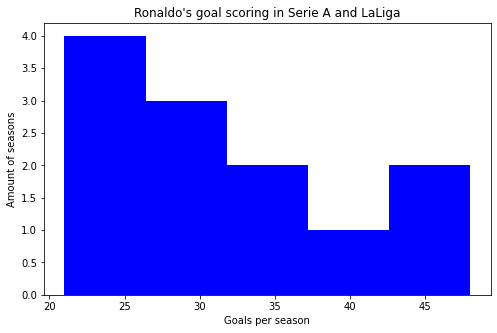

In [5]:
plt.figure(figsize=(8, 5))
plt.hist(x=data_cr7, bins=5, color="blue")
plt.title("Ronaldo's goal scoring in Serie A and LaLiga")
plt.xlabel("Goals per season")
plt.ylabel("Amount of seasons");

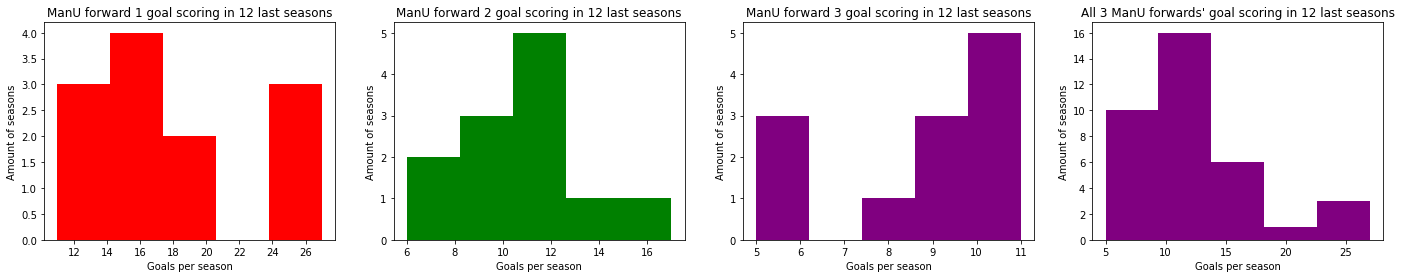

In [6]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(24, 4)

ax[0].hist(x=data_manu[:, 0], bins=5, color="red")
ax[0].set_title("ManU forward 1 goal scoring in 12 last seasons")
ax[0].set_xlabel("Goals per season")
ax[0].set_ylabel("Amount of seasons")

ax[1].hist(x=data_manu[:, 1], bins=5, color="green")
ax[1].set_title("ManU forward 2 goal scoring in 12 last seasons")
ax[1].set_xlabel("Goals per season")
ax[1].set_ylabel("Amount of seasons")

ax[2].hist(x=data_manu[:, 2], bins=5, color="purple")
ax[2].set_title("ManU forward 3 goal scoring in 12 last seasons")
ax[2].set_xlabel("Goals per season")
ax[2].set_ylabel("Amount of seasons");

ax[3].hist(x=data_manu.flatten(), bins=5, color="purple")
ax[3].set_title("All 3 ManU forwards' goal scoring in 12 last seasons")
ax[3].set_xlabel("Goals per season")
ax[3].set_ylabel("Amount of seasons");

## Model 1 - Pooled Model Using ManU Forwards

### Description

In the first model we are going to model Ronaldo's expected goal amount in a season using a pooled model. As data we have the goal amounts of ManU forwards from previous seasons as well as Ronaldo's goal amounts as explained in the Data section. With the data we can form a pooled model of the ManU data and predict what would a new ManU player (Ronaldo) score in a season. By using the historical data from other ManU forwards we add the "ManU style of play" into the model as it is likely that each team in EPL has its own style of play and therefore also own amount of goals scored. 

<b>Model</b><br>
As goals can be thought to have random arrivals during the season, we could make a common assumption that the arrivals of goals are independent and they follow an exponential distribution. Therefore, the amount of these arrivals follows a poisson distribution. Therefore, we can approximate the amount of goals in a season as a counting process which follows a Poisson distribution (number of goals in a season). Therefore, we can use as our likelihood the following:

$$
y \sim Poisson(\lambda)
$$

As prior we know that the mean must be positive, therefore also the lambda which is same as the mean in Poisson distributions. We also know that the Gamma distribution belongs to the conjugate family of Poisson distribution and is always positive. Therefore we could use as prior for the parameter lambda a gamma distribution, which is also often used as the prior for a Poisson distribution. Better be safe than sorry in our model:

$$
\lambda \sim gamma(\alpha, \beta)
$$

Now, what should we use as the values for our parameters. In a Gamma distribution alpha is the shape parameter and beta is the inverse of scale parameter. The mean of the Gamma distribution is alpha divided by beta. For our first prior we could forget the all this theory and use a weakly informative prior such as:
$$
\lambda \sim gamma(0.001, 0.001)
$$
which has a long tail and accepts any data as typical for it. This is also plotted below.

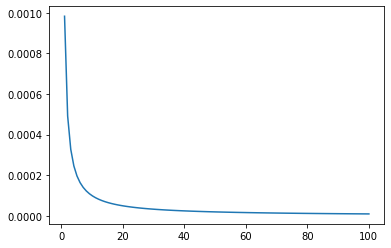

In [7]:
alpha = 0.001
beta = 0.001
x = np.linspace(0, 100, 100)
y = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x, y);

However, as we have some knowledge of Ronaldo's past performance, let's not use only a boring weakly informative prior. Let's try an informative one. To add prior knowledge of Ronaldo's goals, we can try to change the alpha and beta in our prior to fit the goals scored by Ronaldo. To fit the prior distribution with our previous data we could for example modify alpha and beta so that the data is inside the 90% percentile interval of the Gamma distribution. However, this would be quite hard for the Gamma distribution. Therefore, an alternative approach is selected. Let's first find out the smallest amount of goals Ronaldo scored and the largest, as well as the mean and the standard deviation.

In [8]:
s = data_cr7.min()
l = data_cr7.max()
m = data_cr7.mean()
std = data_cr7.std()
print(f"Smallest: {s}\nLargest: {l}\nMean: {m:.2f}\nStandard deviation: {std:.2f}");

Smallest: 21
Largest: 48
Mean: 32.67
Standard deviation: 8.05


Now we want values between 21 and 48 be within the highest probability density. We want also the mean to be around the real mean of the data and therefore alpha divided by beta should be approximately 33. We could  use the Method of Moments to get our estimates for alpha and beta obtaining the following values:
$$
\alpha = \frac{E[X]^{2}}{Var[X]} = 16.5
$$
$$
\beta = \frac{E[X]}{Var[X]} = 0.5
$$
With these values alpha divided by beta is 33. Let's try to plot these values to see if they look reasonable.

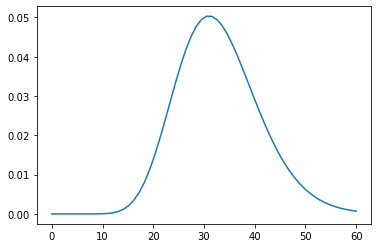

In [9]:
alpha = 16.5
beta = 0.5
x = np.linspace(0, 60, 60)
y = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x, y);

With alpha = 16.5 and beta = 0.5 the distribution looks like it would represent Ronaldo's previous goals. Let's use these parameters in our informative prior distribution.
$$
\lambda \sim gamma(16.5, 0.5)
$$

### Stan model

In [10]:
# STAN CODE
stan_list = []
with open("./models/pooled.stan") as file:
    for line in file:
        stan_list.append(line)
stan_code = "".join(stan_list)
print(stan_code)

data {
    int<lower=0> N; // NUMBER OF SEASONS (12)
    int y[N]; // HISTORICAL DATA
    real<lower=0> alpha; // PARAMETER FOR GAMMA DISTRIBUTION
    real<lower=0> beta; // PARAMETER FOR GAMMA DISTRIBUTION
}
parameters {
    real<lower=0> la; // LAMBDA FOR POISSON
}
model {
    target += gamma_lpdf(la | alpha, beta); // PRIOR
    target += poisson_lpmf(y | la); // LIKELIHOOD
}
generated quantities {
    real pred = poisson_rng(la); // PREDICTION FOR CR7

    vector[N] log_lik;
      for (i in 1:N)
        log_lik[i] = poisson_lpmf(y[i] | la);
}


### Implementation

In the models we are going to use 3 different chains with 4000 samples and 4000 warm-up samples, as warm-up of one half of the total samples is a conservative approach that should guarantee that the chains have converged. 

First the model with weakly informative prior:

In [11]:
# STAN MODEL
nest_asyncio.apply()
inputs = {'N': data_manu.shape[0]*data_manu.shape[1], 'y': data_manu.flatten(), 'alpha': 0.001, 'beta': 0.001}
model = stan.build(program_code=stan_code, data=inputs);
weakly_pooled_fit = model.sample(num_chains=3, num_samples=4000, num_warmup=4000, save_warmup=False);
weakly_pooled_df = weakly_pooled_fit.to_frame()

Building...



Building: 23.3s, done.Messages from stanc:
Sampling:   0%
Sampling:  33% (8000/24000)
Sampling:  67% (16000/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


Then the model with informative prior:

In [12]:
# STAN MODEL
nest_asyncio.apply()
inputs = {'N': data_manu.shape[0]*data_manu.shape[1], 'y': data_manu.flatten(), 'alpha': 16.5, 'beta': 0.5}
model = stan.build(program_code=stan_code, data=inputs);
informative_pooled_fit = model.sample(num_chains=3, num_samples=4000, num_warmup=4000, save_warmup=False);
informative_pooled_df = informative_pooled_fit.to_frame()

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:  33% (8000/24000)
Sampling:  67% (16000/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


### Convergence diagnostics

Now that we have built the models and obtained the samples we should check that our chains have converged. To check the convergency we will first use visual inspection, in other words we will plot the chains (lambda values) and see if they mix together.

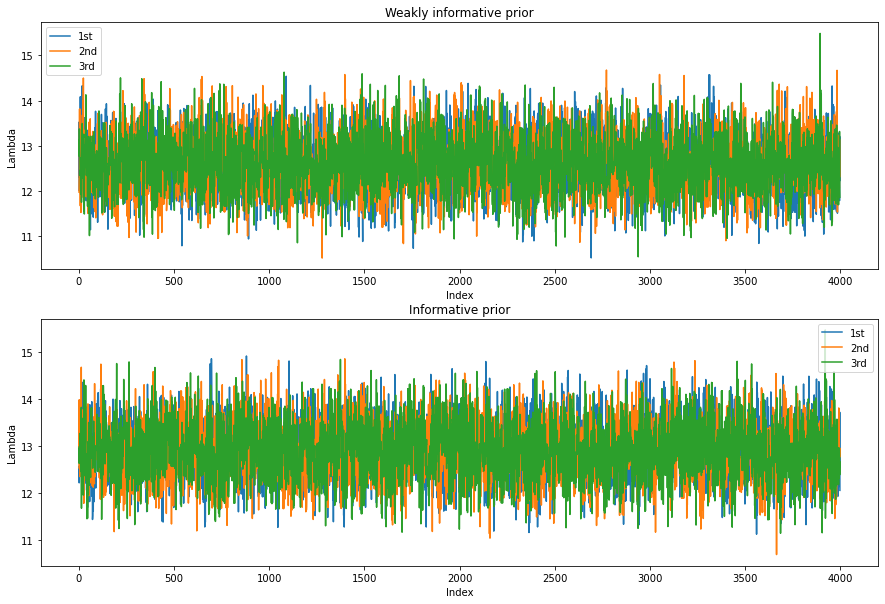

In [13]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax[0].plot(range(4000), weakly_pooled_fit["la"][0][0:4000], label="1st")
ax[0].plot(range(4000), weakly_pooled_fit["la"][0][4000:8000], label="2nd")
ax[0].plot(range(4000), weakly_pooled_fit["la"][0][8000:12000], label="3rd")
ax[0].legend()
ax[0].set_title("Weakly informative prior")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Lambda")

ax[1].plot(range(4000), informative_pooled_fit["la"][0][0:4000], label="1st")
ax[1].plot(range(4000), informative_pooled_fit["la"][0][4000:8000], label="2nd")
ax[1].plot(range(4000), informative_pooled_fit["la"][0][8000:12000], label="3rd")
ax[1].legend()
ax[1].set_title("Informative prior")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Lambda");

The chains seem to mix well together both in the weakly informative prior model and also in the informative prior model. We could also check the convergency with R_hat-value, which compares the within-chain variance with the between-chain variance. If the chains have converged the R_hat will be close to 1 or in other words less than 1.01 as the within-chain variance should be equal to the between-chain variance (they should not differ).

In [14]:
weakly_chains = np.array((weakly_pooled_fit["la"][0][0:4000], 
                    weakly_pooled_fit["la"][0][4000:8000], weakly_pooled_fit["la"][0][8000:12000]))
informative_chains = np.array((informative_pooled_fit["la"][0][0:4000], 
                    informative_pooled_fit["la"][0][4000:8000], informative_pooled_fit["la"][0][8000:12000]))
print(f"Weakly informative chains' R_hat: {az.rhat(weakly_chains)}\nInformative chains' R_hat: {az.rhat(informative_chains)}")

Weakly informative chains' R_hat: 1.0001221039426396
Informative chains' R_hat: 1.0005175250100204


From the R_hat values we can see that the chains have in both models clearly converged.

### Posterior predictive checking

Now that we know that our chains have converged in both models, we would like to assess the predictive performance of the models. To assess this, we use Pareto-smoothed importance sampling leave-one-out cross validation (PSIS-LOO-CV).

First for the weakly informative prior.

In [15]:
az.loo(weakly_pooled_fit, pointwise=True)

Computed from 12000 by 36 log-likelihood matrix

         Estimate       SE
elpd_loo  -118.91    10.30
p_loo        2.46        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       36  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

From the summary we can see that all the k_hat values are under 0.5 which means that the estimate converges quickly. The estimates seem to be reliable. We can also plot these k_hat values.

<AxesSubplot:xlabel='Data Point', ylabel='Shape parameter k'>

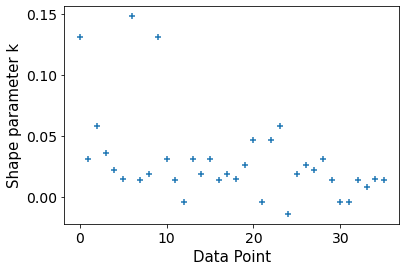

In [17]:
khats = az.loo(weakly_pooled_fit, pointwise=True)
az.plot_khat(khats)

The k_hat values are well below 0.5. This means that the variance of the raw importance ratios is finite, the central limit theorem holds and the estimate converges quickly. Therefore we can consider the PSIS-LOO estimate reliable. From the summary we can also see that the elpd_loo-cv value of the model is -118.91 and the effective number of parameters 2.46.

Next we can check these for the informative prior pooled model.

In [18]:
az.loo(informative_pooled_fit, pointwise=True)

Computed from 12000 by 36 log-likelihood matrix

         Estimate       SE
elpd_loo  -118.92     9.83
p_loo        2.31        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       36  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

All the k_hat values are again below 0.5. Then we can plot these values.

<AxesSubplot:xlabel='Data Point', ylabel='Shape parameter k'>

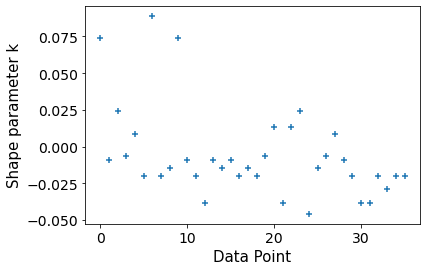

In [19]:
khats = az.loo(informative_pooled_fit, pointwise=True)
az.plot_khat(khats)

The k_hat values are extremely small and therefore the estimates converges quickly. We can consider the PSIS-LOO estimate very reliable. From the summary we can see that the elpd_loo-cv value for this model is -118.92 and the effective number of parameters 2.31.

After checking the predictive performance of the models, we would like to know what the models are predicting for Ronaldo's goal amount. To check this we could first plot the histograms of the predicted goal amounts.

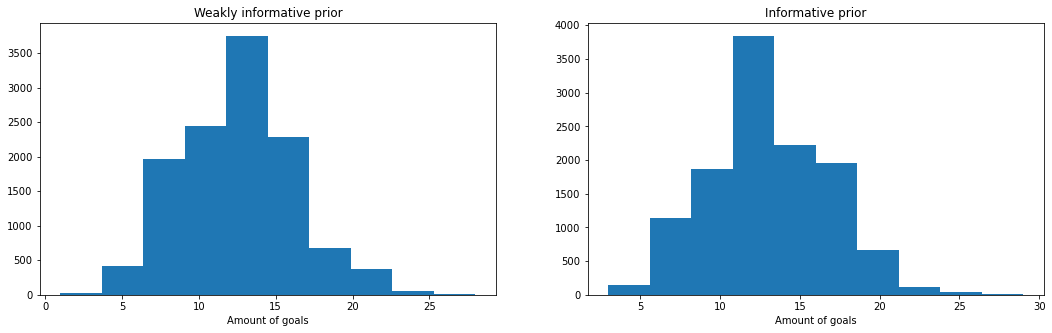

In [20]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 5)

ax[0].hist(weakly_pooled_fit["pred"][0])
ax[0].set_title("Weakly informative prior")
ax[0].set_xlabel("Amount of goals")
ax[1].hist(informative_pooled_fit["pred"][0])
ax[1].set_title("Informative prior")
ax[1].set_xlabel("Amount of goals");

From the histograms we can see that the informative prior doesn't seem to affect the prediction that much. This means that our data in the model plays much bigger role in the predictions. Let's then get the expected goal amount from both models and the 90% credible interval. Before we calculate these values we should get the Monte Carlo Standard Error so that we know how many decimals to report (we should only report digits for which MCSE is 0).

In [21]:
weakly_mcse = az.mcse(np.array((weakly_pooled_fit["la"][0][0:4000], 
                    weakly_pooled_fit["la"][0][4000:8000], weakly_pooled_fit["la"][0][8000:12000])))
informative_mcse = az.mcse(np.array((informative_pooled_fit["la"][0][0:4000], 
                    informative_pooled_fit["la"][0][4000:8000], informative_pooled_fit["la"][0][8000:12000])))
print(f"For the weakly informative prior model (mean): {weakly_mcse[0]}")
print(f"For the informative prior model (mean): {informative_mcse[0]}")

For the weakly informative prior model (mean): 0.007901151308243056
For the informative prior model (mean): 0.00781338300507358


In [22]:
weakly_mcse_q = az.mcse(np.array((weakly_pooled_fit["la"][0][0:4000], 
                    weakly_pooled_fit["la"][0][4000:8000], weakly_pooled_fit["la"][0][8000:12000])), method="quantile", prob=0.9)
informative_mcse_q = az.mcse(np.array((informative_pooled_fit["la"][0][0:4000], 
                    informative_pooled_fit["la"][0][4000:8000], informative_pooled_fit["la"][0][8000:12000])), method="quantile", prob=0.9)
print(f"For the weakly informative prior model (quantile): {weakly_mcse_q}")
print(f"For the informative prior model (quantile): {informative_mcse_q}")

For the weakly informative prior model (quantile): 0.012511379855834726
For the informative prior model (quantile): 0.01106685259545781


First for the model that uses weakly informative prior.

In [23]:
m1 = weakly_pooled_fit["pred"][0].mean()
ci = (np.percentile(weakly_pooled_fit["pred"][0], 5), np.percentile(weakly_pooled_fit["pred"][0], 95))
print(f"Expectation for the mean: {m1:.2f}")
print(f"90 % Credible interval: ({ci[0]:.1f}, {ci[1]:.1f})")

Expectation for the mean: 12.56
90 % Credible interval: (7.0, 19.0)


Then for the model that uses informative prior.

In [24]:
m2 = informative_pooled_fit["pred"][0].mean()
cj = (np.percentile(informative_pooled_fit["pred"][0], 5), np.percentile(informative_pooled_fit["pred"][0], 95))
print(f"Expectation for the mean: {m2:.2f}")
print(f"90 % Credible interval: ({cj[0]:.1f}, {ci[1]:.1f})")

Expectation for the mean: 12.92
90 % Credible interval: (7.0, 19.0)


From the results we can see that there is no big difference between the expectations of the predictions from the two models as the model that uses weakly informative prior predicts 12.56 goals for Ronaldo next season and the model that uses an informative prior predicts 12.92 goals. Both models have also same credible intervals. Therefore, we could deduce that the model is not very sensitive to the selected prior. Both the models have the same elpd-values, but as the k_hats of the informative prior model are much lower, the estimates for that model are more reliable. In addition, the informative model uses information of Ronaldo's past performance. Therefore, we are going to select informative prior model's result as our prediction from the pooled model.

<b>Pooled model prediction: 12.92</b>

### Additional analysis

Now that we have a prediction for Ronaldo's goal scoring in 2021-2022 Premier League season, we are going to assess how valuable each expected goal of Ronaldo is for Manchester United. As stated in the Background-section, we know that Ronaldo cost Manchester United £12.85 million + a yearly salary of £20 million (in this project). As the deal is a two-year deal, Ronaldo's cost for one season is £26.425 million. Therefore, the expected value of one goal scored by Ronaldo is:
$$
Value = \frac{£26.425 million}{12.87}=£2.053million
$$

### Problems in the model

There are some problems in our model even though it is relatively simple. For example, we are assuming that the goals scored by a player in a season follow a Poisson distribution. The model also uses data from Ronaldo's past seasons only as a prior, which makes the predictions more dependent on the Manchester United data. This can be a justified decision but one should take this fact into account.

## Model 2 - Hierarchical Model Using ManU Forwards

### Description

In the first hierarchical model we are going to model Ronaldo's expected goal amount in a season using a hierarchical model, where we are going to use also the goal scoring of other Manchester United forwards in previous seasons. As each team in EPL have their own style of playing, we can argue that there also is a specific amount of goals that usually occur from that style of playing. Therefore, we could assume that Ronaldo's goal amount in ManU shirt is related to the goal amount of other ManU forwards and therefore we could use a hierarchical model, where we take advantage of the data we have from the other forwards.<br>

Now, we could take the easy way like in the pooled model and make our predictions just by using the ManU forward population (scored goals in each season), give some weakly informative hyperpriors and sample hyperparameters for the priors for each player, create a fitting likelihood function and sample a predictive distribution for a new player coming in the ManU team (Ronaldo). However, Ronaldo is not some random player coming to the club, but one of the best players in the world. How can we add this knwoledge of Ronaldo's skills to our model, while still keeping the information from the ManU forward population distribution? One possible way, which is used in this model, is to obtain the prior for Ronaldo's goal scoring from the ManU population distribution and add Ronaldo's skills to the model through data from his past goal scoring in LaLiga and Serie A.<br>

<b>The model</b><br>

As hyperpriors we are going to use for sigma


### Stan model

As the resulting posterior distribution is hard to compute, we are going to sample from it using Markov Chain Monte Carlo methods. To do this, we use a software called Stan and its Python library PyStan3. Stan uses dynamic Hamiltonian Monte Carlo (by default No-U-Turn Sampler, NUTS) as the MCMC-method to sample from the posterior distribution as it needs fewer Markov Chain samples to converge than for example Gibbs sampling.

Stan implementation of the model:

In [ ]:
# STAN CODE
stan_list = []
with open("./models/hierarch1.stan") as file:
    for line in file:
        stan_list.append(line)
hier_stan = "".join(stan_list)
print(hier_stan)

### Implementation

In [ ]:
# STAN MODEL
nest_asyncio.apply()
inputs = {'N': data_manu.shape[0], 'J': data_manu.shape[1], 'y1': data_manu, 'y2': data_cr7}
model = stan.build(program_code=hier_stan, data=inputs);
hier_fit = model.sample();
hier_df = hier_fit.to_frame()

In [ ]:
hier_fit["pred4"].mean()

### Convergence diagnostics

### Posterior predictive checking

### Sensitivity analysis

### Decision analysis

### Problems in the model

<b>Exchangeability</b><br>
First problem of our model is that the groups in the ManU forward data are not clearly exchangeable as we know that they are selected so that the first group is the best forward, second group the second best and the third one the third best. However, as we know that they all are samples from the same population distribution (ManU forward goal scoring distribution), I claim that this knowledge of their order does not matter in this context and as we model a prior distribution from this hierarchical model for the real posterior distribution, we are using a two level hierarchical model that models also the variation between the groups and therefore only partial exchangeablity is needed. Also, we do not have knowledge that the first forward is <b>better</b> at scoring, we just have data where he has scored more goals. Therefore, I claim that we can assume that all the groups are from the same distribution and the data just happens to be ordered.

## Model 3 - Hierarchical model using new Premier League Forwards

## Model comparison

## Sources

Santos-Fernandez, E. & Wu, P. & Mengerson, K. L. (2019). Bayesian statistics meets sports: a comprehensive review. Journal of Quantitative Analysis in Sports. Vol. 15(4). S. 289-312.

Daily Mail. (2021). REVEALED: Manchester United will pay Cristiano Ronaldo £6MILLION-a-year LESS than his Juventus wage as returning superstar agrees to salary cut... but he'll still be the highest earner at Old Trafford. 